# <ins> Prédiction de la quantité d'energie (SiteEnergyUse(kBtu) ) </ins>

Import des bibliothèques 

In [ ]:
!pip install plotly  #Installation de plotly pour l'affichage des certains graphiques

In [308]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.dummy import DummyRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
import warnings
from sklearn import set_config
set_config(display='diagram')
from sklearn.ensemble import *
warnings.filterwarnings('ignore')

#plot distribution de la target et voir le scaler à utiliser 

Téléchargement du jeu de données

In [309]:
data_model =pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P3/data.csv',on_bad_lines='skip')
data_model =data_model.drop(['Unnamed: 0'], axis=1)
#data_model =data_model.drop(['index'], axis=1)
data_model.head()

,SiteEnergyUse(kBtu),TotalGHGEmissions,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,age_batiment,LargestPropertyUseType,...,BuildingType,Ratio_buildingParSurface,Ratio_parkingParSurface,SurfaceParetage,ComplianceStatus,Outlier,is_energyStarImputed,pr_steam,pr_natural,pr_elec
0,7226362.5,249.98,1.0,12,88434,0,88434,60.0,89,Hotel,...,NonResidential,1.00,0.000,6802.61538,Compliant,inconnue,False,0.277302,0.176638,0.546060
1,8387933.0,295.86,1.0,11,103566,15064,88502,61.0,20,Hotel,...,NonResidential,0.85,14.545,8630.50000,Compliant,inconnue,False,0.000000,0.613391,0.386609
2,72587024.0,2089.28,1.0,41,956110,196718,759392,43.0,47,Hotel,...,NonResidential,0.79,20.575,22764.52381,Compliant,inconnue,False,0.297113,0.020579,0.682307
3,6794584.0,286.43,1.0,10,61320,0,61320,56.0,90,Hotel,...,NonResidential,1.00,0.000,5574.54545,Compliant,inconnue,False,0.325913,0.266567,0.407519
4,14172606.0,505.01,1.0,18,175580,62000,113580,75.0,36,Hotel,...,NonResidential,0.65,35.312,9241.05263,Compliant,inconnue,False,0.000000,0.621198,0.378802


#Modélisation : Prédiction de la consommation d'énergie

### Selection des variables 
---



In [310]:
X= data_model[['NumberofBuildings','NumberofFloors', 'ENERGYSTARScore','PropertyGFATotal','age_batiment','PrimaryPropertyType','Ratio_parkingParSurface','LargestPropertyUseType','pr_steam','pr_natural','pr_elec']]
Y = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]

### Transformation logarithmique de notre variable **SiteEnergyUse(kBtu)**
---

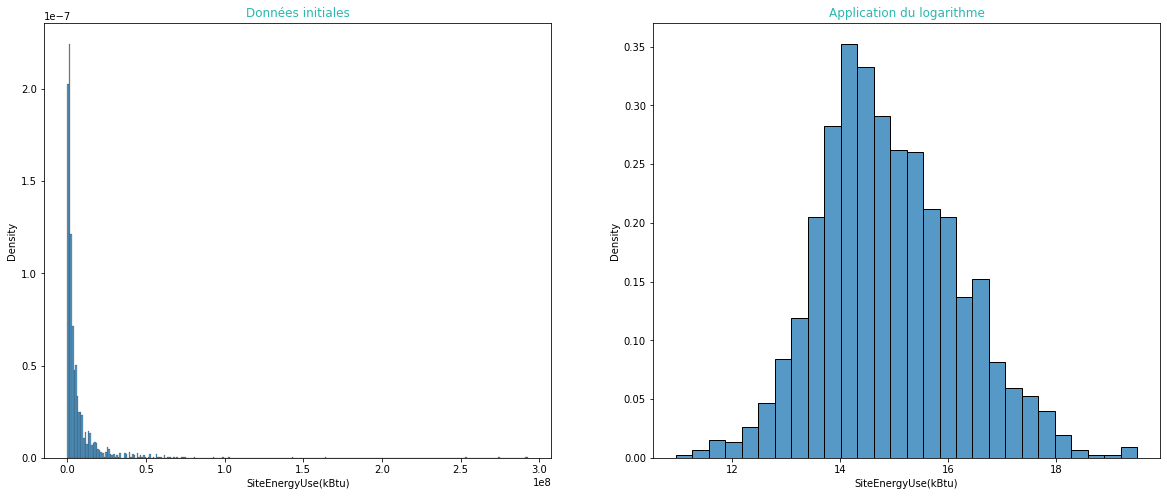

In [311]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
#plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

### Création de Pipeline de transformation des variables : Scaling et One-hot econding 
---

In [312]:
# Séparation des variables numériques et des variables qualitatives
numerical_features  =  ['NumberofBuildings','NumberofFloors','PropertyGFATotal','ENERGYSTARScore','age_batiment','Ratio_parkingParSurface','pr_steam','pr_natural','pr_elec']
categorical_features  = ['PrimaryPropertyType','LargestPropertyUseType']

global  X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=65, shuffle=True)


numerical_pipeline = Pipeline(steps=[
      #('impute', SimpleImputer(strategy='mean')),
      ('scale', StandardScaler())   
  ])
categorical_pipeline= Pipeline(steps=[
      #('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder())
  ])


# Création d'un ColumnTransformer pour appliquer un pipeline pour chaque type de colonne

preprocessor = ColumnTransformer(transformers=[
      ('numerical_pipeline',numerical_pipeline,numerical_features),
      ('categorical_pipeline=',categorical_pipeline,categorical_features )
      ],
      remainder='passthrough',
      n_jobs=-1,
      )


### Modèle baseline
---

In [313]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import  make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

cv = KFold(n_splits=5, shuffle=True, random_state=45)

"""model_baseline= Pipeline(
    steps=[("preprocessor", preprocessor), ("DUM", TransformedTargetRegressor(regressor= BaggingRegressor(random_state=0, n_jobs=-1) ,func=np.log1p, inverse_func=np.expm1))]
)"""
 
"""dummy_param_grid = {'DUM__regressor__base_estimator': [ ElasticNet(alpha=1.5), LinearSVR()],
          'DUM__regressor__n_estimators': [20,50,100],
          'DUM__regressor__max_samples': [0.5,1.0, 2],
          'DUM__regressor__max_features': [0.5,1.0, 2],
          'DUM__regressor__bootstrap': [True, False],
          'DUM__regressor__bootstrap_features': [True, False]}"""


model_baseline= Pipeline(
    steps=[("preprocessor", preprocessor), ("DUM", TransformedTargetRegressor(regressor= DummyRegressor()  ,func=np.log1p, inverse_func=np.expm1))]
)

dummy_param_grid = [ {"DUM__regressor__strategy": ["mean"]} ]   

myscore = ('r2','neg_mean_absolute_error')
dummy_grid_search = GridSearchCV(estimator=model_baseline,
        param_grid=dummy_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=cv,return_train_score=True) 
#cross_val_score(model_baseline, X_train, Y_train['SiteEnergyUse(kBtu)'], cv=cv,scoring=r2)

In [314]:
dumy_model=dummy_grid_search.fit (X_train, Y_train['SiteEnergyUse(kBtu)'])

In [315]:
y_test = Y_test['SiteEnergyUse(kBtu)']
y_pred= dummy_grid_search.predict(X_test)
print ( "R2 : " , round(r2_score (y_test, y_pred),2) ,  "| MAE :", round(mean_absolute_error (y_test, y_pred),2), ' | RMSE :', np.sqrt(round(mean_squared_error (y_test, y_pred),2) ))

R2 :  -0.06 | MAE : 6429863.54  | RMSE : 19107085.00222643


In [316]:
y_train = Y_train['SiteEnergyUse(kBtu)']
y_pred_train= dummy_grid_search.predict(X_train)
print ( "R2 : " , round(r2_score (y_train, y_pred_train),2) ,  "| MAE :", round(mean_absolute_error (y_train, y_pred_train),2), ' | RMSE :', np.sqrt(round(mean_squared_error (y_train, y_pred_train),2) ))

R2 :  -0.06 | MAE : 6327332.56  | RMSE : 19405602.063545022


Qualité prédictive de notre modèle baseline.

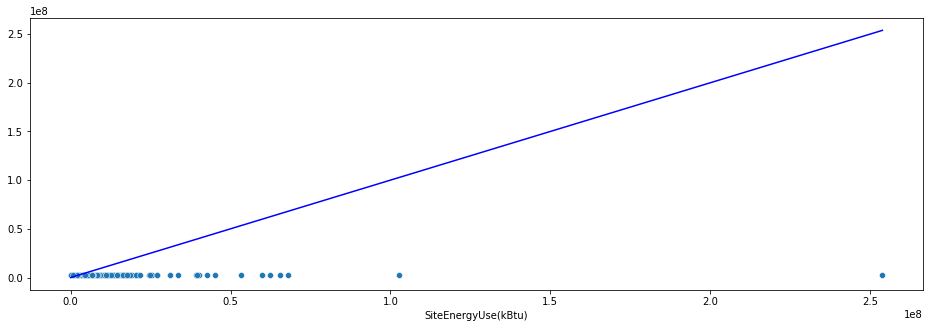

In [317]:
# traçage de y_test versus y_pred
# l'idéal c'est que tous les points doivent le plus possible être aliognés sur la droite.

plt.figure(figsize=(16,5))
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
sns.scatterplot(x=y_test, y=y_pred)

In [318]:
print ( "R2 : " , round(r2_score (y_test, y_pred),2) ,  "| MAE :", round(mean_absolute_error (y_test, y_pred),2), ' | RMSE :', np.sqrt(round(mean_squared_error (y_test, y_pred),2) ))

R2 :  -0.06 | MAE : 6429863.54  | RMSE : 19107085.00222643


### Code get feauture name

In [319]:
# Code copié à partir du site : https://bbakiu.medium.com/extracting-feature-names-from-the-columntransformer-f1bed520aeba
import warnings

from sklearn.pipeline import Pipeline

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    
    
    # Get columns and bin edges
    def pair_bin_edges_columns(bins_edges, columns):
        all_edge_column = []
        for index in range(len(columns)):
            bin_edge = bins_edges[index]
            column = columns[index]
            
            pair_bin_edge = []
            # match consecutive bin edges together
            for first, second in zip(bin_edge, bin_edge[1:]):
                pair_bin_edge.append((first, second))
            
            bin_edge_column = [column +": ["+ str(edge[0]) +", "+ str(edge[1])+")"  for edge in pair_bin_edge]
            all_edge_column.extend(bin_edge_column)
        return all_edge_column
    
    
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            
            # For transformers that create bins
            if hasattr(trans, 'bin_edges_'):
                bins_edges = trans.bin_edges_
                pairs_edges_columns = pair_bin_edges_columns(bins_edges, column)
            if column is None:
                return []
            else:
                return [name + "__" + f for f in pairs_edges_columns]
        return [name + "__" + f for f in trans.get_feature_names(column)]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [320]:
#feat_importances.plot(kind='barh(a'"')

### GridSearch pour les différents modèles 
---

Pipeline, paramètre  et Gridsearch de tous les modèles à tester. J'ai en premier effectué un RandomisedSearch pour détecter les meilleurs hyperparamètre pour chaque modèle, puis j'ai effectué un GridSearch avec les paramètres trouvés avec le RandomisedSearch. Cela premet de réduire le temps d'execution de notre code vu qu'on peut être amené à l'excuter plusieurs fois.

In [321]:
#Régression linéaire multiple
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
nb_split = 5
score = ['accuracy','neg_mean_absolute_error']

pipe_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("LR", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1) )]
)

myscore = ('r2','neg_mean_absolute_error','neg_mean_squared_error')

lr_param_grid = [ {"LR__regressor__fit_intercept": [True, False]}   ] 


lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid, refit='neg_mean_absolute_error',
        scoring=myscore, n_jobs=-1,
        cv=nb_split,return_train_score=True)


#Elastic Net

pipe_elastic = Pipeline(
    steps=[("preprocessor", preprocessor), ("ELN", TransformedTargetRegressor(regressor=ElasticNet() ,func=np.log, inverse_func=np.exp) )]
)
## Paramaètre du randomize search
"""elastic_param_grid = [     {"ELN__regressor__max_iter": [10, 100, 1000],
                            "ELN__regressor__alpha": np.logspace(-5, 5, num=10),  # alpha plus grand --- - 5 à 5 , augmenter la granularité
                             "ELN__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1) } ]   """

elastic_param_grid ={'ELN__regressor__alpha': [1.5],
 'ELN__regressor__l1_ratio':[ 0.0 ],
 'ELN__regressor__max_iter': [100]}

elastic_grid_search = GridSearchCV(estimator=pipe_elastic,
        param_grid=elastic_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split,return_train_score=True) 

# Linear SVM
pipe_lsvr =Pipeline(
    steps=[("preprocessor", preprocessor), ("LSVR", TransformedTargetRegressor(regressor=LinearSVR() ,func=np.log, inverse_func=np.exp) )]
)

"""lsvr_param_grid = [      {'LSVR__regressor__C' : np.logspace(-4, 0, 5),
                          'LSVR__regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
                         'LSVR__regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
                          'LSVR__regressor__max_iter': [10, 100, 1000]}   ] """


lsvr_param_grid ={'LSVR__regressor__C': [0.1],
 'LSVR__regressor__epsilon': [0.01],
 'LSVR__regressor__loss': ['squared_epsilon_insensitive'],
 'LSVR__regressor__max_iter': [10]}



lsvr_grid_search = GridSearchCV(estimator=pipe_lsvr,
        param_grid=lsvr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)


# Random Forest
pipe_rfr= Pipeline(
    steps=[("preprocessor", preprocessor), ("RFR", TransformedTargetRegressor(regressor=RandomForestRegressor() ,func=np.log, inverse_func=np.exp) )]
)

# Paramètre pour le Randomize search
"""rfr_param_grid = [ {'RFR__regressor__max_features' : ['sqrt', 'log2'],
                   'RFR__regressor__max_depth': [15, 25, 200],
                   'RFR__regressor__min_samples_split': [2, 7, 8],
                   'RFR__regressor__bootstrap' : [True, False],
                   'RFR__regressor__min_samples_leaf': [1,2,5]}"""

rfr_param_grid={'RFR__regressor__bootstrap': [False],
                'RFR__regressor__max_depth': [25,50],
                'RFR__regressor__max_features': ['sqrt'],
                'RFR__regressor__min_samples_leaf': [1],
                'RFR__regressor__min_samples_split': [2]}
                                                      
rfr_grid_search = GridSearchCV(estimator=pipe_rfr,
       param_grid=rfr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)                                                  
                                                 
# Rajouter une métrique pour GridSearch
# Xgboost Regressor


pipe_extra = Pipeline(
    steps=[("preprocessor", preprocessor), ("MLP", TransformedTargetRegressor(regressor=ExtraTreesRegressor(random_state=0) ,func=np.log, inverse_func=np.exp) ) ] 
)

## Paramaètre du randomize search
"""  {'MLP__regressor__n_estimators':[350,500],
         'MLP__regressor__max_depth':[8,9,10],
         'MLP__regressor__min_samples_split':[3,4,6],
         'MLP__regressor__min_samples_leaf':[2,3,4],
         'MLP__regressor__max_features':[0.95],
         'MLP__regressor__min_impurity_decrease':[1e-5,1e-4,0]}  """

## Paramètre choisis  pour le gridsearch après le Randomize search
param_grid_mlp = {'MLP__regressor__n_estimators': [350],
 'MLP__regressor__min_samples_split':[ 3],
 'MLP__regressor__min_samples_leaf': [2],
 'MLP__regressor__min_impurity_decrease': [1e-05],
 'MLP__regressor__max_features': [0.95],
 'MLP__regressor__max_depth': [10]}




extraTree_grid_search = GridSearchCV(estimator=pipe_extra,
        param_grid =param_grid_mlp,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True) 

# Gradient boost
pipe_gb= Pipeline(
    steps=[("preprocessor", preprocessor), ("GB", TransformedTargetRegressor(regressor=GradientBoostingRegressor() ,func=np.log, inverse_func=np.exp) )]
)

# Paramètre du randomized Search
"""param_grid_GrBoostR = [{'GB__regressor__n_estimators': [350,500,700], 
                        'GB__regressor__max_depth': [5,6,7], 
                        'GB__regressor__min_samples_split': [2,3,4], 
                        'GB__regressor__learning_rate': [0.01,0.1], 
                        'GB__regressor__loss': ['ls'],
                       "GB__regressor__random_state" : [0]
                       }] """

param_grid_GrBoostR={'GB__regressor__random_state': [0],
                    'GB__regressor__n_estimators': [350],
                    'GB__regressor__min_samples_split': [3],
                    'GB__regressor__max_depth': [5],
                    'GB__regressor__loss': ['ls'],
                    'GB__regressor__learning_rate': [0.1]}

gb_grid_search =  GridSearchCV(estimator=pipe_gb,
         param_grid=param_grid_GrBoostR,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)   


Architecture de base de chaque modèle

In [322]:
lr_grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('numerical_pipeline',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                          'ENERGYSTARScore',
                                                                          'age_batiment',
                                                                          'Ratio_parkingParSurface',
                                                                          'pr_steam',
                                                                          'pr_natural',
                                                                          'pr_elec']),
                                                                        ('cat...
                                                                         ['PrimaryPropertyType',
                                                                          'LargestPropertyUseType'])])),
                                       ('LR',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=LinearRegression()))]),
             n_jobs=-1,
             param_grid=[{'LR__regressor__fit_intercept': [True, False]}],
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'))

### Entrainement des modèles et choix des meilleurs modèles après le GridSearch
---

In [323]:
global target
global R
global lr_grid_search_model , elastic_grid_search_model, lsvr_grid_search_model, rfr_grid_search_model , mlp_grid_search_model, gb_grid_search_model
target = ['SiteEnergyUse(kBtu)', 'SiteEnergyUse(kBtu)']


In [324]:
def train_model (model) :
  mymod = model.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
  y_test = Y_test['SiteEnergyUse(kBtu)']
  y_pred= mymod.predict(X_test)
  print ( "R2 : " , round(r2_score (y_test, y_pred),2) ,  "| MAE :", round(mean_absolute_error (y_test, y_pred),2), ' | RMSE :', round( np.sqrt(mean_squared_error (y_test, y_pred)),2))
  return mymod.best_params_


In [325]:
%%time
#target_x =target[0]
lr_grid_search_model = lr_grid_search.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
elastic_grid_search_model = elastic_grid_search.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
lsvr_grid_search_model = lsvr_grid_search.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
rfr_grid_search_model = rfr_grid_search.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
mlp_grid_search_model = extraTree_grid_search.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
gb_grid_search_model = gb_grid_search.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])

CPU times: user 5.31 s, sys: 43.8 ms, total: 5.36 s
Wall time: 25.8 s


On met tous nos modèles dans un dictionnaire

In [326]:
modele ={ 'Linear Regression': lr_grid_search_model, 'Elastic Net' : elastic_grid_search_model , 'Linear SVR': lsvr_grid_search_model ,
         'RandomForest':rfr_grid_search_model, 'ExtraTree Regressor':mlp_grid_search_model,'GradientBoost' : gb_grid_search_model}

###  Choix du meilleur modèle pour la variable target SiteEnergyUse(kBtu)
---

Metrics de la cross validation du Gridsearch des meilleurs modèles trouvés

In [327]:
a=pd.DataFrame(lr_grid_search_model.cv_results_)[[	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params', ]].head(1)
b=pd.DataFrame(elastic_grid_search_model.cv_results_)[[	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params',]].head(1)
c=pd.DataFrame(lsvr_grid_search_model.cv_results_)[['mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params',	]].head(1)
d=pd.DataFrame(rfr_grid_search_model.cv_results_)[[	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params',]].head(1)
e=pd.DataFrame(mlp_grid_search_model.cv_results_)[[	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params',]].head(1)
f=pd.DataFrame(gb_grid_search_model.cv_results_)[[	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params',]].head(1)

R=pd.concat([a, b,c,d,e,f])
R["Modèles"] = ['LinearRegression', 'ElasticNet', 'Linear SVR', 'RandomForest', 'Extratree Regressor', 'GradientBoost']

cols =R.columns.tolist()
cols = cols[-1:] + cols[:-1]
R= R[cols] 
R.rename(columns={'mean_fit_time' :'fit time', 'mean_test_neg_mean_absolute_error' : 'MAE (moyen)','mean_test_neg_mean_squared_error' : 'MSE (moyen)','mean_test_r2' :'R2 (moyen)'	,'std_train_neg_mean_absolute_error': 'std_MAE'}, inplace=True)
R['MAE (moyen)'] = -R['MAE (moyen)']
R['MSE (moyen)'] = -R['MSE (moyen)']
R
#R['RMSE'] = -R['RMSE']

,Modèles,fit time,MAE (moyen),MSE (moyen),R2 (moyen),std_MAE,params
0,LinearRegression,0.096929,1.856052e+07,1.382858e+17,-161.270299,1.423435e+06,{'LR__regressor__fit_intercept': True}
0,ElasticNet,0.098554,5.227897e+06,2.806912e+14,0.182791,2.442778e+05,"{'ELN__regressor__alpha': 1.5, 'ELN__regressor..."
0,Linear SVR,0.042033,1.511442e+07,4.086795e+16,-70.730897,2.338372e+06,"{'LSVR__regressor__C': 0.1, 'LSVR__regressor__..."
0,RandomForest,1.001912,3.444908e+06,1.948329e+14,0.505325,4.292528e+03,"{'RFR__regressor__bootstrap': False, 'RFR__reg..."
0,Extratree Regressor,2.928978,3.225074e+06,1.834118e+14,0.572884,7.818406e+04,"{'MLP__regressor__max_depth': 10, 'MLP__regres..."
0,GradientBoost,1.643147,3.141721e+06,1.797540e+14,0.576081,2.494843e+04,"{'GB__regressor__learning_rate': 0.1, 'GB__reg..."


### Qualité de prediction du meilleur modèle choisi après le GridSearch.
---

In [328]:
# Metrics sur le train set
dict_train={}
for m in modele.keys() :
  y_pred =modele[m].best_estimator_.predict(X_train)
  dict_train[m] = [round(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'],y_pred),3) , round(np.sqrt(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'],y_pred)) ,2), round((mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'],y_pred)),2),round((r2_score(Y_train['SiteEnergyUse(kBtu)'],y_pred)),2)  ]

# Metrics sur les test set
dict_test={}

for m in modele.keys() :
  y_pred =modele[m].best_estimator_.predict(X_test)
  dict_test[m] = [ round(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'],y_pred),3) ,round(np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'],y_pred)) ,2), round((mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'],y_pred)),2),round((r2_score(Y_test['SiteEnergyUse(kBtu)'],y_pred)),2) ]



### Qualité de prédiction de chaque modèle du GridSearch sur le test set et le train set 
---

In [329]:
#Prédiction sur le train set
print ("                           Metrics sur le Train set")
metrics=pd.DataFrame(dict_train)
metrics.index = (["MSE","RMSE","MAE","R2"])
display(metrics.T)

print("\n")
# Prédiction sur le test set
print ("                           Metrics sur le Test set")
metrics=pd.DataFrame(dict_test)
metrics.index = (["MSE","RMSE","MAE","R2"])
display(metrics.T)


                           Metrics sur le Train set


,MSE,RMSE,MAE,R2
Linear Regression,1.389203e+16,1.178645e+08,9328032.50,-38.07
Elastic Net,2.764813e+14,1.662773e+07,5207249.06,0.22
Linear SVR,1.591244e+16,1.261445e+08,10699264.63,-43.76
RandomForest,7.630311e+09,8.735165e+04,10820.17,1.00
ExtraTree Regressor,4.836043e+13,6.954166e+06,1952986.53,0.86
GradientBoost,1.231822e+12,1.109875e+06,458467.41,1.00




                           Metrics sur le Test set


,MSE,RMSE,MAE,R2
Linear Regression,3.927385e+14,19817630.11,4577263.70,-0.14
Elastic Net,3.121517e+14,17667814.32,5501142.83,0.09
Linear SVR,1.079339e+15,32853290.55,5838563.57,-2.14
RandomForest,1.330873e+14,11536347.82,3267046.06,0.61
ExtraTree Regressor,1.201544e+14,10961497.44,3399096.72,0.65
GradientBoost,3.596329e+13,5996940.21,2501317.50,0.90


Avec la graphique ci-dessus, on constate que le modèle GradientBoost offre le meilleur score **MAE** et un meilleur $R^2$ (~0.8) . On rentiendra ce modèle pour la modélisation de la 
variable **TotalGHGEmissions** est donc le modèle GradientBoost.

### Temps d'entrainement de chaque modèles
---

In [330]:
import plotly.graph_objects as go
fig = go.Figure([ go.Bar(name='temps entraînement',x=R['Modèles'], y=R['fit time'])])
fig.update_layout(barmode='group',autosize=False, width=700, height=400)

fig.show()

### Code pour tracer les performances sur train et le test set de la cross validation du grid search

In [331]:
import plotly.express as px
def trace_mae(mymodel) :
  t1=pd.DataFrame(mymodel.cv_results_)[["split0_train_neg_mean_absolute_error",	"split1_train_neg_mean_absolute_error","split2_train_neg_mean_absolute_error",	"split3_train_neg_mean_absolute_error",	"split4_train_neg_mean_absolute_error"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
  t1=pd.DataFrame(mymodel.cv_results_)[["split0_train_neg_mean_absolute_error",	"split1_train_neg_mean_absolute_error","split2_train_neg_mean_absolute_error",	"split3_train_neg_mean_absolute_error","split4_train_neg_mean_absolute_error"]]
  t2= pd.DataFrame(mymodel.cv_results_)[["split0_test_neg_mean_absolute_error",	"split1_test_neg_mean_absolute_error","split2_test_neg_mean_absolute_error",	"split3_test_neg_mean_absolute_error",	"split4_test_neg_mean_absolute_error"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
  t2= pd.DataFrame(mymodel.cv_results_)[["split0_test_neg_mean_absolute_error",	"split1_test_neg_mean_absolute_error","split2_test_neg_mean_absolute_error",	"split3_test_neg_mean_absolute_error",	"split4_test_neg_mean_absolute_error"]]

  df1_transposed = t1.T
  df1_transposed 
  df2_transposed = t2.T
  final=pd.concat ([df1_transposed,df2_transposed ])
  final["Split_cross validation"] = list(range(nb_split)) + list(range(nb_split))
  final.rename(columns={0: "MAE"}, inplace=True)
  final=final.reset_index()
  final ["color"] = np.where( final["index"].str.contains("test"), "test", "train")
  final

  fig = px.line( final, x='Split_cross validation',y='MAE', color='color', symbol="color",width=800, height=400)
  fig.show()

def trace_r2(mymodel) :
    t1=pd.DataFrame(mymodel.cv_results_)[["split0_train_r2",	"split1_train_r2","split2_train_r2",	"split3_train_r2",	"split4_train_r2"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
    t1=pd.DataFrame(mymodel.cv_results_)[["split0_train_r2",	"split1_train_r2","split2_train_r2",	"split3_train_r2","split4_train_r2"]]
    t2= pd.DataFrame(mymodel.cv_results_)[["split0_test_r2",	"split1_test_r2","split2_test_r2",	"split3_test_r2",	"split4_test_r2"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
    t2= pd.DataFrame(mymodel.cv_results_)[["split0_test_r2",	"split1_test_r2","split2_test_r2",	"split3_test_r2",	"split4_test_r2"]]

    df1_transposed = t1.T
    df1_transposed 
    df2_transposed = t2.T
    final=pd.concat ([df1_transposed,df2_transposed ])
    final["Split_cross validation"] = list(range(nb_split)) + list(range(nb_split))
    final.rename(columns={0: "R2"}, inplace=True)
    final=final.reset_index()
    final ["color"] = np.where( final["index"].str.contains("test"), "test", "train")
    final

    fig = px.line( final, x='Split_cross validation',y='R2', color='color', symbol="color",width=800, height=400)
    fig.show()



### Performance de notre modèle selectionné dans le train et le test set de chaque split de la cross-validation du Gridsearch


In [332]:
trace_mae(gb_grid_search_model)
trace_r2(gb_grid_search_model)

On voit bien ici que la performance du modèle sur les données se rapproche de celle sur les données de test. On peut ne pas envisager un overffiting de notre modèle séléctionné.

### Feature importance du meilleur modèle
---

In [333]:
#Poids de chaque feature dans le modèle
feature_importance_value1=gb_grid_search_model.best_estimator_.named_steps['GB'].regressor_.feature_importances_ 

#Noms de features utilisés dans le modèle
feature_names = get_feature_names(gb_grid_search_model.best_estimator_.named_steps['preprocessor'])

#Dataframe regroupant les features et leur poids
feat_importances1= pd.Series(feature_importance_value1 , index=feature_names)

In [334]:
#Création et transposition de la dataframe feature importance
feat_importances1= pd.DataFrame(feat_importances1).transpose()

#Agrégation des features qui proviennent de la même variable qualitative
feat_importances1['PrimaryPropertyType']= feat_importances1[list(feat_importances1.filter(regex='one-hot__x0'))].sum(axis=1)
feat_importances1['LargestPropertyUseType']= feat_importances1[list(feat_importances1.filter(regex='one-hot__x1'))].sum(axis=1)
#feat_importances1["BuildingType"]= feat_importances1[list(feat_importances1.filter(regex='one-hot__x2'))].sum(axis=1)

# Colonnes à supprimer 
unwanted = feat_importances1.columns[feat_importances1.columns.str.startswith('one-hot__x')]
feat_importances1.drop(unwanted, axis=1, inplace=True)

#On ramène la dataFrame à sa forme initiale
feat_importances1= pd.DataFrame(feat_importances1).transpose()

#On renomme et reformate les valeurs de la colonne feature
df2=feat_importances1.reset_index().rename(columns={"index": "features", 0: "poids"})
df2['features']=df2['features'].str.replace('numerical_pipeline__','')


### Tracé feature importance

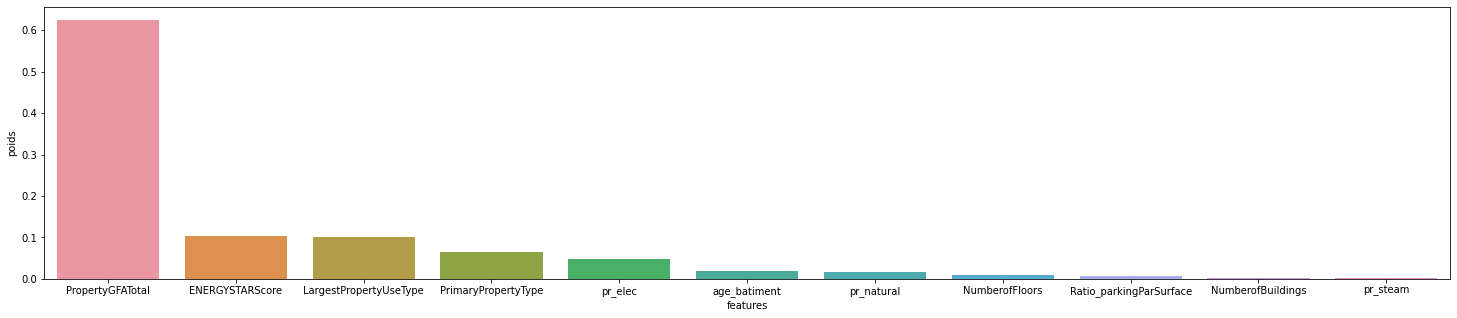

In [335]:
#On trace le graphique du feature importance 
plt.figure(figsize=(25.2,5))
sns.barplot(x='features', y='poids', data=df2.sort_values(by='poids', ascending=False))

On voit sur ce graphique les features qui ont plus d'impact sur notre modèle.

A partir de ce graphique, nous pouvons décider de supprimer les features qui ont très peu d'importance. On obtiendra un modèle plus simple et sans doute avec une moindre variance. 

On peut  aussi regarder sur quelles données le meilleurs modèle fait de grosses erreur, et essayer de comprendre pourquoi: des donnée atypique ? manque-t-il un feature pour les capter ?  Données abbérentes ? faut-il les supprimmer ? 

### Valeurs prédites vs Valeurs réelles de notre meilleur modèle.
---

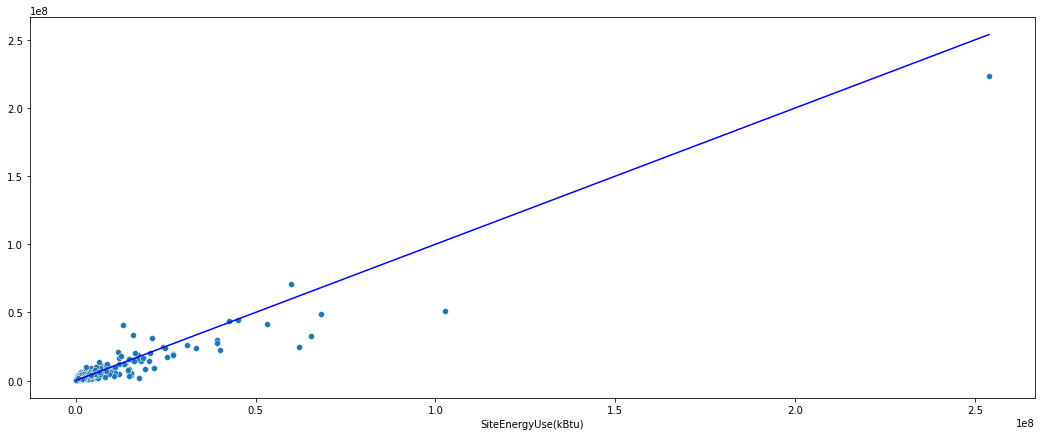

In [336]:
y_pred =gb_grid_search_model.best_estimator_.predict(X_test)
plt.figure(figsize=(18,7))
y_test=Y_test[target[0]]
# traçage de y_test versus y_pred
# l'idéal aurait dû être une ligne droite
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
sns.scatterplot(x=y_test, y=y_pred)

# <ins>Importance de EnergyStarScore pour la variable target SiteEnergyUse(kBtu)</ins>

Nous allons voir si EnergyStar a un impact sur les modèles. On enlève la variable ENERGYSTARScore

### GridSearch

In [337]:
#X1= data_model[['NumberofBuildings','NumberofFloors','PropertyGFATotal','age_batiment','PrimaryPropertyType','Ratio_parkingParSurface']]
#Y1 = data_model[['SiteEnergyUse(kBtu)','SiteEnergyUse(kBtu)']]

# Création de piepeline pour les features numériques et catégoriels   ----  'SiteEnergyUse(kBtu)','SiteEnergyUse(kBtu)',
numerical_features1  =  ['NumberofBuildings','NumberofFloors','PropertyGFATotal','age_batiment','Ratio_parkingParSurface','pr_steam','pr_natural','pr_elec']
categorical_features1  = ['PrimaryPropertyType','LargestPropertyUseType'] #'LargestPropertyUseType',"BuildingType"



numerical_pipeline1 = Pipeline(steps=[
      #('impute', SimpleImputer(strategy='mean')),
      ('scale', StandardScaler())   
  ])
categorical_pipeline1= Pipeline(steps=[
      #('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder())
  ])

  # Création d'un ColumnTransformer pour appliquer un pipeline pour chaque type de colonne

preprocessor = ColumnTransformer(transformers=[
      ('numerical_pipeline1',numerical_pipeline1,numerical_features1),
      ('categorical_pipeline1=',categorical_pipeline1,categorical_features1 )
      ],
      remainder='passthrough',
      n_jobs=-1,
      )

#X = data_model.drop(['SiteEnergyUse(kBtu)','SiteEnergyUse(kBtu)'], axis=1)
#Y = data_model[['SiteEnergyUse(kBtu)','SiteEnergyUse(kBtu)']]

#Régression linéaire multiple
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
nb_split = 5
score = ['accuracy','neg_mean_absolute_error']

pipe_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("LR", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1) )]
)

myscore = ('r2','neg_mean_absolute_error')

lr_param_grid = [ {"LR__regressor__fit_intercept": [True, False]}   ] 


lr_grid_search1 = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid, refit='neg_mean_absolute_error',
        scoring=myscore, n_jobs=-1,
        cv=nb_split,return_train_score=True)


#Elastic Net

pipe_elastic = Pipeline(
    steps=[("preprocessor", preprocessor), ("ELN", TransformedTargetRegressor(regressor=ElasticNet() ,func=np.log, inverse_func=np.exp) )]
)
## Paramaètre du randomize search
"""elastic_param_grid = [     {"ELN__regressor__max_iter": [10, 100, 1000],
                            "ELN__regressor__alpha": np.logspace(-5, 5, num=10),  # alpha plus grand --- - 5 à 5 , augmenter la granularité
                             "ELN__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1) } ]   """

elastic_param_grid ={'ELN__regressor__alpha': [0.0],
 'ELN__regressor__l1_ratio':[ 0.0 ],
 'ELN__regressor__max_iter': [100]}

elastic_grid_search1 = GridSearchCV(estimator=pipe_elastic,
        param_grid=elastic_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split,return_train_score=True) 

# Linear SVM
pipe_lsvr =Pipeline(
    steps=[("preprocessor", preprocessor), ("LSVR", TransformedTargetRegressor(regressor=LinearSVR() ,func=np.log, inverse_func=np.exp) )]
)

"""lsvr_param_grid = [      {'LSVR__regressor__C' : np.logspace(-4, 0, 5),
                          'LSVR__regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
                         'LSVR__regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
                          'LSVR__regressor__max_iter': [10, 100, 1000]}   ]  """


lsvr_param_grid ={'LSVR__regressor__C': [0.01],
 'LSVR__regressor__epsilon': [1],
 'LSVR__regressor__loss': ['epsilon_insensitive'],
 'LSVR__regressor__max_iter': [10]}

lsvr_grid_search1 = GridSearchCV(estimator=pipe_lsvr,
        param_grid=lsvr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)


# Random Forest
pipe_rfr= Pipeline(
    steps=[("preprocessor", preprocessor), ("RFR", TransformedTargetRegressor(regressor=RandomForestRegressor() ,func=np.log, inverse_func=np.exp) )]
)

# Paramètre pour le Randomize search
"""rfr_param_grid = [ {'RFR__regressor__max_features' : ['sqrt', 'log2'],
                   'RFR__regressor__max_depth': [15, 25, 200],
                   'RFR__regressor__min_samples_split': [2, 7, 8],
                   'RFR__regressor__bootstrap' : [True, False],
                   'RFR__regressor__min_samples_leaf': [1,2,5]}"""

rfr_param_grid={'RFR__regressor__bootstrap': [False],
                'RFR__regressor__max_depth': [25,50],
                'RFR__regressor__max_features': ['sqrt'],
                'RFR__regressor__min_samples_leaf': [1],
                'RFR__regressor__min_samples_split': [2]}
                                                      
rfr_grid_search1 = GridSearchCV(estimator=pipe_rfr,
       param_grid=rfr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)                                                  
                                                 
# Rajouter une métrique pour GridSearch
# Xgboost Regressor


pipe_extra = Pipeline(
    steps=[("preprocessor", preprocessor), ("MLP", TransformedTargetRegressor(regressor=ExtraTreesRegressor(random_state=0) ,func=np.log, inverse_func=np.exp) ) ] 
)

## Paramaètre du randomize search
"""  {'MLP__regressor__n_estimators':[350,500],
         'MLP__regressor__max_depth':[8,9,10],
         'MLP__regressor__min_samples_split':[3,4,6],
         'MLP__regressor__min_samples_leaf':[2,3,4],
         'MLP__regressor__max_features':[0.95],
         'MLP__regressor__min_impurity_decrease':[1e-5,1e-4,0]}  """

## Paramètre choisis  pour le gridsearch après le Randomize search
param_grid_mlp = {'MLP__regressor__n_estimators': [350],
 'MLP__regressor__min_samples_split':[ 3],
 'MLP__regressor__min_samples_leaf': [2],
 'MLP__regressor__min_impurity_decrease': [1e-05],
 'MLP__regressor__max_features': [0.95],
 'MLP__regressor__max_depth': [10]}




extraTree_grid_search1 = GridSearchCV(estimator=pipe_extra,
        param_grid =param_grid_mlp,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True) 

# Gradient boost
pipe_gb= Pipeline(
    steps=[("preprocessor", preprocessor), ("GB", TransformedTargetRegressor(regressor=GradientBoostingRegressor() ,func=np.log, inverse_func=np.exp) )]
)

# Paramètre du randomized Search
"""param_grid_GrBoostR = [{'GB__regressor__n_estimators': [350,500,700], 
                        'GB__regressor__max_depth': [5,6,7], 
                        'GB__regressor__min_samples_split': [2,3,4], 
                        'GB__regressor__learning_rate': [0.01,0.1], 
                        'GB__regressor__loss': ['ls'],
                       "GB__regressor__random_state" : [0]
                       }] """

param_grid_GrBoostR={'GB__regressor__random_state': [0],
                    'GB__regressor__n_estimators': [350],
                    'GB__regressor__min_samples_split': [3],
                    'GB__regressor__max_depth': [5],
                    'GB__regressor__loss': ['ls'],
                    'GB__regressor__learning_rate': [0.1]}

gb_grid_search1 =  GridSearchCV(estimator=pipe_gb,
         param_grid=param_grid_GrBoostR,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)   





import warnings
warnings.filterwarnings('ignore')



target = ['SiteEnergyUse(kBtu)', 'SiteEnergyUse(kBtu)']

global R1, y_test_predict1,lr_grid_search_model1 ,elastic_grid_search_model1,lsvr_grid_search_model1 , rfr_grid_search_model1


lr_grid_search_model1 = lr_grid_search1.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
elastic_grid_search_model1 = elastic_grid_search1.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
lsvr_grid_search_model1 = lsvr_grid_search1.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
rfr_grid_search_model1 = rfr_grid_search1.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
extraTree_grid_search_model1 = extraTree_grid_search1.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
gb_grid_search_model1 = gb_grid_search1.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])


### Impact de EnergyStarUse sur SiteEnergyUse(kBtu)
---

In [338]:
#Prédiction sans energyStarScore
y_test_predict1 = gb_grid_search_model1.predict(X_test)

v_avec =  [round((r2_score(Y_test['SiteEnergyUse(kBtu)'],y_pred)),3), round((mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'],y_pred)),3)]
v_sans=[round((r2_score(Y_test['SiteEnergyUse(kBtu)'],y_test_predict1)),3), round((mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'],y_test_predict1)),3)]

pd.DataFrame({ "Metrics": ["R2", "MAE"], "Modèle avec EnergyStarScore" : v_avec, "Modèle sans EnergyStarScore" : v_sans })


,Metrics,Modèle avec EnergyStarScore,Modèle sans EnergyStarScore
0,R2,0.895,0.903
1,MAE,2501317.502,2438275.522


In [339]:
print( "Evolution MAE", round(((v_sans[1] -v_avec[1]) /v_avec[1])*100,2), "%" )
print( "Evolution MAE", round( ((v_sans[0] -v_avec[0]) /v_avec[0])*100,2)  )

Evolution MAE -2.52 %
Evolution MAE 0.89


Sans l'energyStarScore le MAE baisse de 2.5%  et le R2 s'améliore de 0.89%

Conclusion : L'energyStar Score n'a pas trop impact sur la qualité du modèle.